<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Let's look at the data in given file

In [23]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [2]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


##### Let's look at some sentences


In [25]:
print(rus_trn[13][0])
print(rus_trn[13][1])
print(rus_trn[24][0])
print(rus_trn[24][1])


устрицы подают с простыми винами типа рислинга
%% u1 s t r' 'ix ts ax # p ax d a' j' 'u1 t # s _ p r a s t y'1 m' 'ix' # v' 'i1 n ax' m' 'ix' # t' 'i1 p ax' # r' 'i1 s l' 'ix n g a %%
отношение числа городских и сельских жителей четыре к одному
%% a t n a sh e'1 n' 'ix' jax' # ch' 'i s l a1 # g ax r a ts k' 'i1 h # y' _ s' 'e'1 l' s k' 'ix gh # zh y'1 t' 'ix' l' 'ix' j' %% %% ch' 'i t y'1 r' 'ix # k _ ax d n a m u1 %%


#### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


#### Let's see if we have dupliates in corpus

In [26]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentences: 3131 out of 50277
Unique trans sentences: 3171 out of 50277


#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

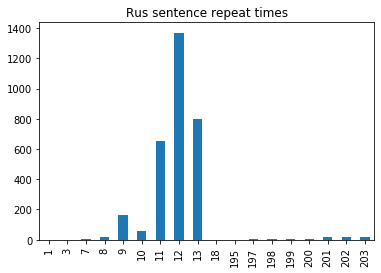

In [27]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the words. We'll count the words in each sentence. If the count in rus and trans is different, we'll record it as anomaly


Anomalies: 49


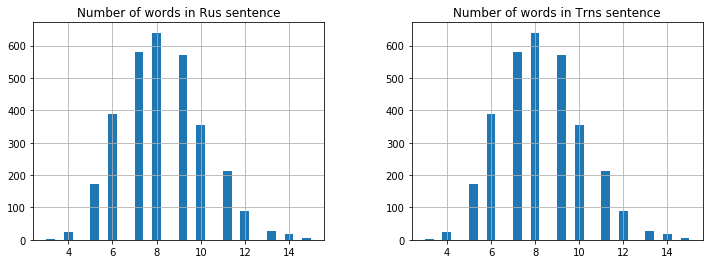

In [3]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])  

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

#### So we have 49 anomalies out of 3131 samples

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

Number of times "-" used: 159


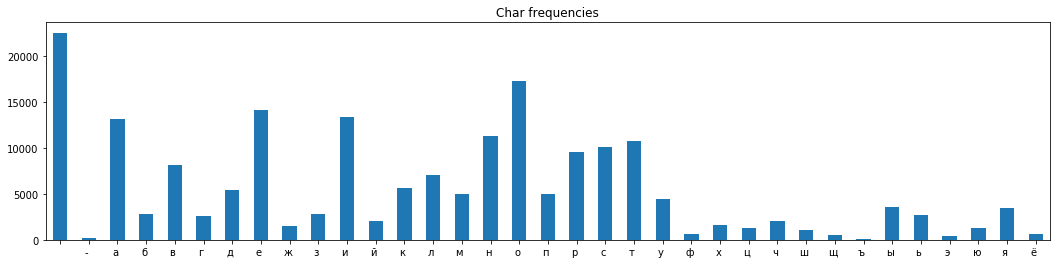

In [29]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [30]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

['анти-обледенитель', 'иридо-диагностика', 'дом-красавец', 'из-за', 'радио-сигналом', 'ноль-три', 'ноль-два', 'мало-обеспеченные', 'шкаф-купе', 'тех-осмотр', 'пресс-службе', 'авто-сервис', 'чуть-чуть', 'аудио-', 'какие-либо', 'де-факто', 'стерео-', 'царь-колокол', 'царь-пушка', 'гео-магнитного', 'электро-катастрофы', 'фигуристы-новобранцы', 'что-то', 'какое-либо', 'веб-операторы', 'воздушно-десантной', 'военно-морских', 'ветераны-афганцы', 'одного-единственного', 'природно-климатические', 'одном-двух', 'санкт-петербурге', 'стран-участниц', 'пять-шесть', 'по-своему', 'матч-реванш', 'словаря-справочника', 'штаб-квартире', 'чем-то', 'чего-то', 'экс-губернатора', 'российско-американский', 'северо-восточных', 'красно-белую', 'какой-нибудь', 'бело-жёлтый', 'карту-схему', 'юго-западный', 'радио-охранное', 'по-прежнему', 'каким-то', 'кино-картины', 'авто-трюки', 'пресс-конференции', 'генерал-прокурором', 'нью-йорке', 'медиа-группы', 'нью-йоркской', 'какие-то', 'санкт-петербурга', 'санкт-петерб

#### Okey, words with dash look fine, we'll consider dash as a normal letter

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentenses rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' and remove begin and end markers. Plus to that let's get rid of duplicates.


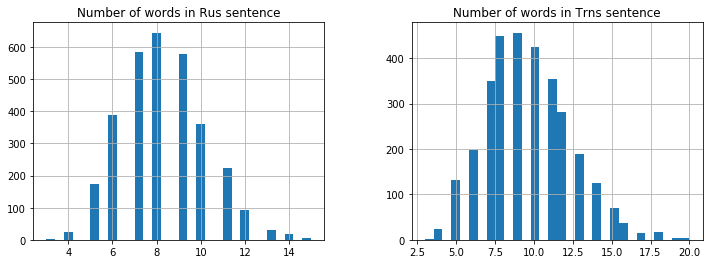

In [4]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []

for j,(rus, trn) in enumerate(rus_trn):

  if rus not in seen_rus and trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      trn = trn.replace('%% %%', '#%% %%#').replace('_', '#_#')[2:-2]
      res.append((rus, trn))

      rus_l.append( len(rus.split()))
      trn_l.append( len(trn.split('#')))
      # if len(trn.split('#')) > 17:
      #   print(rus)
      #   print(trn)

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [0]:
# trn = re.split(r'#|(_|%% %%)',rus_trn[0][1][2:-2])
# trn = list(filter(None, trn))
# '#'.join(trn)

### Text to Sequence Conversion

In [0]:
def tokenization(lines, split=' '):
  tokenizer = Tokenizer(filters='', split=split)
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [6]:
rus_tokenizer = tokenization(rus_trn_new[:, 0])
rus_vocab_size = len(rus_tokenizer.word_index) + 1
trn_tokenizer = tokenization(rus_trn_new[:, 1], split='#')
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print('Rus Vocabulary Size: %d' % rus_vocab_size)
print('Trns Vocabulary Size: %d' % trn_vocab_size)

Rus Vocabulary Size: 12176
Trns Vocabulary Size: 13696


In [0]:
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

### Model Building


In [0]:
train, test = train_test_split(rus_trn_new, test_size=0.1, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

In [54]:
# build NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

model = define_model(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 128)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 15, 128)           1558528   
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 20, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 20, 128)           131584    
_________________________________________________________________
dense_6 (Dense)              (None, 20, 13696)         1766784   
Total params: 3,588,480
Trainable params: 3,588,480
Non-trainable params: 0
_________________________________________________________________


Train on 2817 samples, validate on 313 samples
Epoch 1/30
2817/2817 [==============================] - 10s 4ms/step - loss: 3.9790 - val_loss: 4.8142
Epoch 2/30
2817/2817 [==============================] - 3s 926us/step - loss: 3.8638 - val_loss: 4.9938
Epoch 3/30
2817/2817 [==============================] - 3s 920us/step - loss: 3.8426 - val_loss: 4.9968
Epoch 4/30
2817/2817 [==============================] - 3s 926us/step - loss: 3.8293 - val_loss: 4.9789
Epoch 5/30
2817/2817 [==============================] - 3s 930us/step - loss: 3.7625 - val_loss: 5.0744
Epoch 6/30
2817/2817 [==============================] - 3s 934us/step - loss: 3.7775 - val_loss: 4.9275


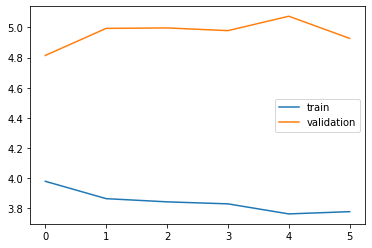

In [62]:
optimizer = optimizers.RMSprop(lr=0.001)
# optimizer=optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

momitor = 'val_loss'
mode = 'min'
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor=momitor, verbose=1, save_best_only=True, mode=mode)
early_stop = EarlyStopping( patience=5, monitor=momitor, mode=mode)

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    validation_data=(testX, testY.reshape(testY.shape[0], testY.shape[1], 1)),
                    epochs=30, batch_size=256, callbacks=[early_stop], 
                    verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [59]:
# model = load_model('model.h5')
preds = model.predict_classes(testX)
preds

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [15]:
testY

array([[    2,     1,   708, ...,     0,     0,     0],
       [    4,     1,  6505, ...,     0,     0,     0],
       [    2,     1,  8048, ...,     0,     0,     0],
       ...,
       [    2,     1,  2042, ...,     0,     0,     0],
       [    4,     1, 12441, ...,     0,     0,     0],
       [   38,    15,     1, ...,     0,     0,     0]], dtype=int32)

In [17]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == n:
          return word
  return None
  
t = []
for e in testX[2]:
  s = get_word(e, rus_tokenizer)
  if s: t.append(s)
print( ' '.join(t) )

t = []
for e in testY[2]:
  s = get_word(e, trn_tokenizer)
  if s: t.append(s)
print( '#'.join(t) )

в дневном меню порции меньше и стоимость ниже
 v #_# d' n' 'i v n o1 m # m' 'i' n' 'u1 # p o1 r ts ax' i' # m' 'e'1 n' sh ax' # i #_# s t o'1 i m ax' s' t' # n' 'i1 zh e 


In [18]:
preds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
preds_text = []
for i in preds:
  print(i)
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], trn_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], trn_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
            temp.append('')
      else:
              temp.append(t) 

  preds_text.append('#'.join(temp))

pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pred_df.sample(15)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

KeyboardInterrupt: ignored